In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_data():
    mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(np.int32)  # Convert target to integers
    return X, y


def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def avg_pooling(image, pool_size):
    pooled_height = image.shape[0] // pool_size[0]
    pooled_width = image.shape[1] // pool_size[1]
    pooled_image = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            start_i, end_i = i * pool_size[0], (i + 1) * pool_size[0]
            start_j, end_j = j * pool_size[1], (j + 1) * pool_size[1]
            pooled_image[i, j] = np.mean(image[start_i:end_i, start_j:end_j])

    return pooled_image


def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [2]:
import tqdm

# Load and split the data
X, y = load_data()

pool_size = 3
X_pooled = np.zeros((X.shape[0], (28 // pool_size) * (28 // pool_size)))
for i in tqdm.tqdm(range(X.shape[0])):
    image = X[i].reshape(28, 28)
    pooled_image = avg_pooling(image, (pool_size, pool_size))
    X_pooled[i] = pooled_image.flatten()

X_train, X_test, y_train, y_test = split_data(X_pooled, y)

# Preprocess the data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
100%|██████████| 70000/70000 [00:47<00:00, 1486.23it/s]


In [3]:
import sys
sys.path.append('D:\calvera\src')

In [4]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [5]:
import torch

from neural_bandits.algorithms.neural_ucb_bandit import NeuralUCB
from neural_bandits.trainers.neural_ucb_trainer import NeuralUCBTrainer
from neural_bandits.utils.multiclass import MultiClassContextualiser

def train_neural_ucb_mnist(X_train_scaled, y_train, n_samples: int = 10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_scaled.shape[1]
    n_arms = 10

    network = Network(n_features * n_arms, hidden_size=100)
    
    # Initialize bandit
    bandit = NeuralUCB(
        network=network,
        n_arms=n_arms,
        n_features=n_features * n_arms,
        lambda_=0.00001,
        nu=0.00001,
    ).to(device)
    
    trainer = NeuralUCBTrainer(eta=0.01)
    mc_contextualiser = MultiClassContextualiser(n_arms)
    
    total_regret = []
    
    for t in tqdm.tqdm(range(n_samples)):
        x_tensor = torch.tensor(X_train_scaled[t], dtype=torch.float32).to(device).reshape(1, -1)
        contextualised_actions = mc_contextualiser.contextualise(x_tensor)
        # print("contextualised_actions.shape: ", contextualised_actions.shape)
        
        # Select action
        ucb_scores = bandit(contextualised_actions)
        chosen_arm = torch.argmax(ucb_scores, dim=1).item()
        
        # Get reward
        reward = 1.0 if y_train[t] == chosen_arm else 0.0
        reward = torch.tensor([reward], dtype=torch.float32, device=device).reshape(1, -1)
        total_regret.append(1 - reward.item())
        
        # Extract features for chosen arm
        contextualised_actions = contextualised_actions.squeeze(0)
        chosen_features = contextualised_actions[chosen_arm]
        # print("chosen_features.shape: ", chosen_features.shape)
        
        # Update bandit
        if t < 1000:
            bandit = trainer.update(bandit, reward, chosen_features)
        else:
            if t % 100 == 0:
                bandit = trainer.update(bandit, reward, chosen_features)

        if t % 100 == 0:
            print(f"Step {t}:")
            print(f"UCB Scores: {ucb_scores}")
            print(f"Chosen arm: {chosen_arm}")
            print(f"True label: {y_train[t]}")
            print(f"Average regret: {sum(total_regret)/(t+1)}")
    
    return bandit, total_regret

In [6]:
# Train the neural UCB bandit
bandit, regret = train_neural_ucb_mnist(X_train_scaled, y_train)

# Print results
print("Total regret:", sum(regret))
print("Average regret:", sum(regret) / len(regret))

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
  0%|          | 11/10000 [00:01<16:03, 10.36it/s] 

Step 0:
UCB Scores: tensor([[0.0964, 0.0921, 0.0968, 0.1021, 0.1002, 0.1026, 0.0999, 0.1006, 0.1055,
         0.1038]])
Chosen arm: 8
True label: 5
Average regret: 1.0


  1%|          | 101/10000 [00:11<29:20,  5.62it/s]

Step 100:
UCB Scores: tensor([[0.1983, 0.0608, 0.0874, 0.1212, 0.0956, 0.0896, 0.0759, 0.0869, 0.0875,
         0.0969]])
Chosen arm: 0
True label: 0
Average regret: 0.801980198019802


  2%|▏         | 202/10000 [00:37<51:20,  3.18it/s]  

Step 200:
UCB Scores: tensor([[0.0952, 0.0905, 0.1102, 0.0806, 0.0851, 0.0920, 0.1638, 0.1250, 0.0890,
         0.0686]])
Chosen arm: 6
True label: 6
Average regret: 0.6517412935323383


  3%|▎         | 301/10000 [01:03<38:10,  4.23it/s]  

Step 300:
UCB Scores: tensor([[0.0875, 0.0870, 0.0970, 0.2540, 0.0875, 0.0847, 0.0935, 0.0634, 0.0741,
         0.0713]])
Chosen arm: 3
True label: 3
Average regret: 0.5614617940199336


  4%|▍         | 401/10000 [01:41<42:19,  3.78it/s]  

Step 400:
UCB Scores: tensor([[0.0888, 0.0809, 0.0963, 0.0990, 0.1053, 0.0883, 0.0618, 0.1852, 0.0857,
         0.1088]])
Chosen arm: 7
True label: 7
Average regret: 0.5112219451371571


  5%|▌         | 501/10000 [02:22<57:14,  2.77it/s]  

Step 500:
UCB Scores: tensor([[0.0672, 0.2299, 0.0754, 0.0818, 0.0785, 0.0851, 0.0892, 0.1257, 0.0596,
         0.1077]])
Chosen arm: 1
True label: 1
Average regret: 0.4530938123752495


  6%|▌         | 601/10000 [03:03<1:19:23,  1.97it/s]

Step 600:
UCB Scores: tensor([[0.0897, 0.0847, 0.0501, 0.0823, 0.0775, 0.0855, 0.0482, 0.1771, 0.1410,
         0.1639]])
Chosen arm: 7
True label: 7
Average regret: 0.41430948419301167


  7%|▋         | 701/10000 [03:53<1:57:26,  1.32it/s]

Step 700:
UCB Scores: tensor([[0.0686, 0.1887, 0.0814, 0.1280, 0.0956, 0.0729, 0.0608, 0.1433, 0.0676,
         0.0931]])
Chosen arm: 1
True label: 1
Average regret: 0.38373751783166904


  8%|▊         | 801/10000 [05:00<1:46:52,  1.43it/s]

Step 800:
UCB Scores: tensor([[0.1014, 0.0884, 0.0836, 0.1878, 0.0752, 0.1012, 0.0494, 0.1133, 0.0875,
         0.1123]])
Chosen arm: 3
True label: 3
Average regret: 0.36079900124843944


  9%|▉         | 901/10000 [06:24<1:53:44,  1.33it/s]

Step 900:
UCB Scores: tensor([[0.1307, 0.0411, 0.0618, 0.1630, 0.0953, 0.1416, 0.0745, 0.0660, 0.1152,
         0.1108]])
Chosen arm: 3
True label: 5
Average regret: 0.3507214206437292


 10%|█         | 1015/10000 [07:45<18:09,  8.24it/s]  

Step 1000:
UCB Scores: tensor([[0.0681, 0.2131, 0.1441, 0.0817, 0.1000, 0.0810, 0.0617, 0.0713, 0.1096,
         0.0695]])
Chosen arm: 1
True label: 1
Average regret: 0.33466533466533466


 11%|█         | 1118/10000 [07:47<03:06, 47.64it/s]

Step 1100:
UCB Scores: tensor([[0.0879, 0.0924, 0.0753, 0.0648, 0.1214, 0.1005, 0.0847, 0.1131, 0.0833,
         0.1765]])
Chosen arm: 9
True label: 9
Average regret: 0.3097184377838329


 12%|█▏        | 1219/10000 [07:48<02:51, 51.24it/s]

Step 1200:
UCB Scores: tensor([[0.0785, 0.0556, 0.0624, 0.1994, 0.0707, 0.1035, 0.0576, 0.1281, 0.0938,
         0.1504]])
Chosen arm: 3
True label: 9
Average regret: 0.305578684429642


 13%|█▎        | 1320/10000 [07:50<02:52, 50.42it/s] 

Step 1300:
UCB Scores: tensor([[0.0809, 0.0954, 0.1003, 0.3120, 0.0654, 0.1289, 0.0444, 0.0972, 0.0456,
         0.0299]])
Chosen arm: 3
True label: 3
Average regret: 0.29285165257494233


 14%|█▍        | 1428/10000 [07:51<02:40, 53.28it/s] 

Step 1400:
UCB Scores: tensor([[0.1316, 0.0732, 0.0655, 0.1324, 0.0851, 0.1503, 0.0889, 0.0618, 0.1101,
         0.1011]])
Chosen arm: 5
True label: 5
Average regret: 0.28765167737330477


 15%|█▌        | 1520/10000 [07:53<03:21, 42.17it/s]

Step 1500:
UCB Scores: tensor([[0.1107, 0.0858, 0.0671, 0.0359, 0.2246, 0.1354, 0.0782, 0.0890, 0.0191,
         0.1542]])
Chosen arm: 4
True label: 7
Average regret: 0.28247834776815456


 16%|█▌        | 1619/10000 [07:54<02:49, 49.51it/s] 

Step 1600:
UCB Scores: tensor([[0.0588, 0.1283, 0.0730, 0.1335, 0.1219, 0.0975, 0.0829, 0.0917, 0.1608,
         0.0516]])
Chosen arm: 8
True label: 8
Average regret: 0.27420362273579013


 17%|█▋        | 1722/10000 [07:56<02:39, 52.00it/s] 

Step 1700:
UCB Scores: tensor([[0.1635, 0.0343, 0.1236, 0.0689, 0.0761, 0.0993, 0.1065, 0.1585, 0.1103,
         0.0589]])
Chosen arm: 0
True label: 6
Average regret: 0.26866549088771313


 18%|█▊        | 1810/10000 [07:57<03:33, 38.44it/s] 

Step 1800:
UCB Scores: tensor([[0.1150, 0.0470, 0.0841, 0.0540, 0.0861, 0.1170, 0.0805, 0.0919, 0.1246,
         0.1997]])
Chosen arm: 9
True label: 4
Average regret: 0.2670738478622987


 19%|█▉        | 1929/10000 [08:00<02:54, 46.25it/s]

Step 1900:
UCB Scores: tensor([[0.1184, 0.0638, 0.0904, 0.0757, 0.0347, 0.1355, 0.0683, 0.0668, 0.2083,
         0.1382]])
Chosen arm: 8
True label: 8
Average regret: 0.26038926880589164


 20%|██        | 2028/10000 [08:01<02:34, 51.59it/s] 

Step 2000:
UCB Scores: tensor([[0.0682, 0.1016, 0.1145, 0.0473, 0.2121, 0.0879, 0.0653, 0.1593, 0.0490,
         0.0948]])
Chosen arm: 4
True label: 4
Average regret: 0.25537231384307846


 21%|██▏       | 2125/10000 [08:03<02:50, 46.21it/s]

Step 2100:
UCB Scores: tensor([[0.0922, 0.1070, 0.1380, 0.3131, 0.0458, 0.0522, 0.1450, 0.0344, 0.0304,
         0.0419]])
Chosen arm: 3
True label: 3
Average regret: 0.25083293669681106


 22%|██▏       | 2227/10000 [08:04<02:52, 45.15it/s] 

Step 2200:
UCB Scores: tensor([[0.1009, 0.0537, 0.0713, 0.0695, 0.0898, 0.0763, 0.0524, 0.2646, 0.0657,
         0.1559]])
Chosen arm: 7
True label: 7
Average regret: 0.2453430258973194


 23%|██▎       | 2322/10000 [08:06<02:34, 49.81it/s]

Step 2300:
UCB Scores: tensor([[0.0849, 0.0571, 0.2267, 0.0929, 0.1108, 0.0920, 0.0975, 0.1030, 0.0815,
         0.0537]])
Chosen arm: 2
True label: 2
Average regret: 0.24206866579747935


 24%|██▍       | 2425/10000 [08:07<02:18, 54.63it/s] 

Step 2400:
UCB Scores: tensor([[0.2149, 0.0429, 0.1197, 0.0889, 0.0656, 0.1560, 0.1431, 0.0758, 0.0403,
         0.0529]])
Chosen arm: 0
True label: 0
Average regret: 0.23823406913785922


 25%|██▌       | 2521/10000 [08:09<02:15, 55.07it/s] 

Step 2500:
UCB Scores: tensor([[0.2341, 0.0743, 0.1310, 0.0250, 0.1295, 0.1090, 0.1351, 0.1137, 0.0317,
         0.0166]])
Chosen arm: 0
True label: 0
Average regret: 0.23590563774490203


 26%|██▋       | 2628/10000 [08:10<02:13, 55.12it/s] 

Step 2600:
UCB Scores: tensor([[0.0670, 0.0873, 0.0977, 0.1977, 0.0533, 0.1842, 0.0425, 0.0788, 0.1109,
         0.0805]])
Chosen arm: 3
True label: 3
Average regret: 0.23375624759707805


 27%|██▋       | 2722/10000 [08:12<02:09, 56.27it/s] 

Step 2700:
UCB Scores: tensor([[0.0860, 0.1795, 0.1293, 0.1144, 0.0910, 0.0970, 0.0464, 0.0837, 0.0897,
         0.0830]])
Chosen arm: 1
True label: 1
Average regret: 0.23139577934098482


 28%|██▊       | 2813/10000 [08:13<03:25, 35.06it/s] 

Step 2800:
UCB Scores: tensor([[0.0431, 0.2037, 0.1656, 0.1216, 0.0521, 0.1014, 0.0681, 0.0788, 0.0683,
         0.0974]])
Chosen arm: 1
True label: 1
Average regret: 0.22991788646911818


 29%|██▉       | 2915/10000 [08:15<02:40, 44.23it/s]

Step 2900:
UCB Scores: tensor([[0.2053, 0.0556, 0.0714, 0.0282, 0.1485, 0.1007, 0.1589, 0.1407, 0.0354,
         0.0553]])
Chosen arm: 0
True label: 0
Average regret: 0.22819717338848672


 30%|███       | 3030/10000 [08:17<01:47, 65.13it/s]

Step 3000:
UCB Scores: tensor([[0.0876, 0.0974, 0.1193, 0.2045, 0.0583, 0.1051, 0.0400, 0.0732, 0.0834,
         0.1312]])
Chosen arm: 3
True label: 3
Average regret: 0.22492502499166944


 31%|███▏      | 3131/10000 [08:18<01:42, 66.73it/s] 

Step 3100:
UCB Scores: tensor([[0.0428, 0.0766, 0.1365, 0.0515, 0.1868, 0.0956, 0.0465, 0.1384, 0.0499,
         0.1754]])
Chosen arm: 4
True label: 9
Average regret: 0.22444372782973235


 32%|███▏      | 3217/10000 [08:19<02:15, 50.16it/s] 

Step 3200:
UCB Scores: tensor([[0.1016, 0.0752, 0.1162, 0.1209, 0.1709, 0.0925, 0.0913, 0.1631, 0.0367,
         0.0318]])
Chosen arm: 4
True label: 4
Average regret: 0.2218056857232115


 33%|███▎      | 3332/10000 [08:21<01:44, 63.85it/s] 

Step 3300:
UCB Scores: tensor([[0.0389, 0.2353, 0.0745, 0.0605, 0.0467, 0.1016, 0.1136, 0.0602, 0.1816,
         0.0870]])
Chosen arm: 1
True label: 1
Average regret: 0.21993335352923357


 34%|███▍      | 3425/10000 [08:23<02:08, 51.36it/s] 

Step 3400:
UCB Scores: tensor([[0.0458, 0.2223, 0.1741, 0.1108, 0.0315, 0.0873, 0.0715, 0.0483, 0.1326,
         0.0757]])
Chosen arm: 1
True label: 1
Average regret: 0.21964128197588945


 35%|███▌      | 3533/10000 [08:24<01:36, 67.04it/s] 

Step 3500:
UCB Scores: tensor([[0.0839, 0.0435, 0.1266, 0.2944, 0.0774, 0.1055, 0.0387, 0.1013, 0.0741,
         0.0545]])
Chosen arm: 3
True label: 3
Average regret: 0.21793773207654957


 36%|███▌      | 3620/10000 [08:26<02:03, 51.57it/s] 

Step 3600:
UCB Scores: tensor([[0.0836, 0.1000, 0.2578, 0.0840, 0.0774, 0.1039, 0.0972, 0.0715, 0.0947,
         0.0299]])
Chosen arm: 2
True label: 2
Average regret: 0.21827270202721466


 37%|███▋      | 3730/10000 [08:27<01:45, 59.65it/s] 

Step 3700:
UCB Scores: tensor([[0.0423, 0.1409, 0.0820, 0.1933, 0.0483, 0.1115, 0.0486, 0.0585, 0.1532,
         0.1214]])
Chosen arm: 3
True label: 3
Average regret: 0.21669818967846527


 38%|███▊      | 3815/10000 [08:29<02:08, 48.25it/s] 

Step 3800:
UCB Scores: tensor([[0.1024, 0.0829, 0.1602, 0.0551, 0.1159, 0.0686, 0.1061, 0.0823, 0.0565,
         0.1700]])
Chosen arm: 9
True label: 2
Average regret: 0.21441725861615366


 39%|███▉      | 3933/10000 [08:31<01:52, 53.90it/s]

Step 3900:
UCB Scores: tensor([[0.0744, 0.1253, 0.1739, 0.1064, 0.0738, 0.1187, 0.0386, 0.0992, 0.1036,
         0.0861]])
Chosen arm: 2
True label: 8
Average regret: 0.21353499102794155


 40%|████      | 4016/10000 [08:32<02:38, 37.68it/s] 

Step 4000:
UCB Scores: tensor([[0.1001, 0.0928, 0.0579, 0.0768, 0.0981, 0.1251, 0.1026, 0.1373, 0.1362,
         0.0731]])
Chosen arm: 7
True label: 5
Average regret: 0.2129467633091727


 41%|████      | 4116/10000 [08:35<03:10, 30.90it/s]

Step 4100:
UCB Scores: tensor([[0.1322, 0.0855, 0.1155, 0.0679, 0.1567, 0.0995, 0.1209, 0.1248, 0.0529,
         0.0440]])
Chosen arm: 4
True label: 4
Average regret: 0.21189953669836625


 42%|████▏     | 4211/10000 [08:37<03:10, 30.33it/s]

Step 4200:
UCB Scores: tensor([[0.0411, 0.1575, 0.1034, 0.1658, 0.0807, 0.1041, 0.0690, 0.0907, 0.0689,
         0.1189]])
Chosen arm: 3
True label: 1
Average regret: 0.21066412758866937


 43%|████▎     | 4320/10000 [08:39<02:53, 32.77it/s]

Step 4300:
UCB Scores: tensor([[0.0637, 0.0642, 0.0824, 0.0890, 0.2656, 0.1036, 0.0815, 0.0977, 0.0927,
         0.0597]])
Chosen arm: 4
True label: 4
Average regret: 0.20971867007672634


 44%|████▍     | 4419/10000 [08:41<02:09, 43.06it/s]

Step 4400:
UCB Scores: tensor([[0.2581, 0.0135, 0.1267, 0.0540, 0.0672, 0.1318, 0.0789, 0.1051, 0.0771,
         0.0876]])
Chosen arm: 0
True label: 0
Average regret: 0.21040672574414906


 45%|████▌     | 4527/10000 [08:42<01:29, 61.19it/s] 

Step 4500:
UCB Scores: tensor([[0.0592, 0.0518, 0.0461, 0.1102, 0.1128, 0.0913, 0.0315, 0.0289, 0.1838,
         0.2845]])
Chosen arm: 9
True label: 9
Average regret: 0.20706509664518996


 46%|████▌     | 4623/10000 [08:44<01:31, 58.99it/s] 

Step 4600:
UCB Scores: tensor([[0.0766, 0.0755, 0.2667, 0.1032, 0.0189, 0.1323, 0.0892, 0.0526, 0.1107,
         0.0742]])
Chosen arm: 2
True label: 2
Average regret: 0.2066941969137144


 47%|████▋     | 4729/10000 [08:45<01:17, 68.13it/s] 

Step 4700:
UCB Scores: tensor([[0.2387, 0.0581, 0.0739, 0.1235, 0.1220, 0.1335, 0.0747, 0.1299, 0.0204,
         0.0252]])
Chosen arm: 0
True label: 0
Average regret: 0.20548819400127633


 48%|████▊     | 4825/10000 [08:46<01:37, 53.35it/s] 

Step 4800:
UCB Scores: tensor([[0.1024, 0.0459, 0.0885, 0.1108, 0.0842, 0.1702, 0.1058, 0.1349, 0.0976,
         0.0599]])
Chosen arm: 5
True label: 5
Average regret: 0.204540720683191


 49%|████▉     | 4921/10000 [08:48<02:10, 38.94it/s]

Step 4900:
UCB Scores: tensor([[0.0820, 0.0175, 0.1850, 0.0391, 0.1378, 0.0978, 0.1690, 0.0848, 0.1072,
         0.0799]])
Chosen arm: 2
True label: 6
Average regret: 0.20383595184656192


 50%|█████     | 5031/10000 [08:50<01:30, 54.90it/s] 

Step 5000:
UCB Scores: tensor([[0.0380, 0.2447, 0.1105, 0.0910, 0.0561, 0.0923, 0.0831, 0.0682, 0.1220,
         0.0940]])
Chosen arm: 1
True label: 1
Average regret: 0.20295940811837632


 51%|█████▏    | 5132/10000 [08:51<01:18, 62.23it/s] 

Step 5100:
UCB Scores: tensor([[0.0370, 0.1111, 0.1150, 0.0798, 0.0460, 0.1042, 0.0962, 0.0412, 0.2516,
         0.1180]])
Chosen arm: 8
True label: 8
Average regret: 0.20211723191531072


 52%|█████▏    | 5232/10000 [08:52<01:14, 63.75it/s] 

Step 5200:
UCB Scores: tensor([[0.0510, 0.1461, 0.1254, 0.0912, 0.0656, 0.0703, 0.0681, 0.2136, 0.0688,
         0.0998]])
Chosen arm: 7
True label: 7
Average regret: 0.20053835800807537


 53%|█████▎    | 5317/10000 [08:54<01:40, 46.50it/s] 

Step 5300:
UCB Scores: tensor([[0.0795, 0.0950, 0.1017, 0.2609, 0.0884, 0.1766, 0.0390, 0.0605, 0.0771,
         0.0212]])
Chosen arm: 3
True label: 3
Average regret: 0.19864176570458403


 54%|█████▍    | 5430/10000 [08:55<01:14, 61.05it/s] 

Step 5400:
UCB Scores: tensor([[0.0697, 0.0799, 0.2890, 0.0605, 0.0330, 0.0943, 0.1132, 0.0421, 0.1026,
         0.1157]])
Chosen arm: 2
True label: 2
Average regret: 0.19811146084058506


 55%|█████▌    | 5530/10000 [08:56<01:06, 66.97it/s] 

Step 5500:
UCB Scores: tensor([[0.1205, 0.0797, 0.0535, 0.1107, 0.0681, 0.1863, 0.0714, 0.1225, 0.1190,
         0.0681]])
Chosen arm: 5
True label: 5
Average regret: 0.1988729321941465


 56%|█████▋    | 5634/10000 [08:58<01:05, 66.36it/s] 

Step 5600:
UCB Scores: tensor([[0.0963, 0.0328, 0.1227, 0.0609, 0.0613, 0.1077, 0.0966, 0.0447, 0.1705,
         0.2064]])
Chosen arm: 9
True label: 8
Average regret: 0.19710765934654526


 57%|█████▋    | 5724/10000 [08:59<01:03, 67.38it/s] 

Step 5700:
UCB Scores: tensor([[0.0770, 0.1004, 0.0424, 0.0995, 0.2069, 0.0920, 0.0593, 0.1651, 0.0642,
         0.0931]])
Chosen arm: 4
True label: 4
Average regret: 0.1971583932643396


 58%|█████▊    | 5831/10000 [09:00<01:02, 67.08it/s] 

Step 5800:
UCB Scores: tensor([[0.1428, 0.0250, 0.0569, 0.0258, 0.2300, 0.1237, 0.1757, 0.0514, 0.0890,
         0.0799]])
Chosen arm: 4
True label: 4
Average regret: 0.19686260989484572


 59%|█████▉    | 5930/10000 [09:02<01:06, 61.16it/s] 

Step 5900:
UCB Scores: tensor([[0.0803, 0.0793, 0.0265, 0.1650, 0.0916, 0.1967, 0.0496, 0.1246, 0.0896,
         0.0969]])
Chosen arm: 5
True label: 5
Average regret: 0.19488222335197425


 60%|██████    | 6035/10000 [09:03<00:56, 69.73it/s] 

Step 6000:
UCB Scores: tensor([[0.0658, 0.0392, 0.0905, 0.0694, 0.2627, 0.0832, 0.0955, 0.0993, 0.1097,
         0.0848]])
Chosen arm: 4
True label: 4
Average regret: 0.19563406098983502


 61%|██████▏   | 6128/10000 [09:04<00:53, 71.96it/s] 

Step 6100:
UCB Scores: tensor([[0.0886, 0.0835, 0.1035, 0.2361, 0.0435, 0.1647, 0.0803, 0.0293, 0.0963,
         0.0743]])
Chosen arm: 3
True label: 3
Average regret: 0.19537780691689888


 62%|██████▏   | 6218/10000 [09:05<00:57, 65.58it/s] 

Step 6200:
UCB Scores: tensor([[0.2041, 0.0587, 0.1160, 0.0423, 0.0670, 0.1409, 0.1624, 0.1029, 0.0608,
         0.0449]])
Chosen arm: 0
True label: 0
Average regret: 0.19400096758587324


 63%|██████▎   | 6332/10000 [09:07<00:49, 73.83it/s] 

Step 6300:
UCB Scores: tensor([[0.0953, 0.0869, 0.0632, 0.0896, 0.0969, 0.1609, 0.0722, 0.1070, 0.1097,
         0.1183]])
Chosen arm: 5
True label: 8
Average regret: 0.19266783050309474


 64%|██████▍   | 6438/10000 [09:08<00:42, 84.42it/s] 

Step 6400:
UCB Scores: tensor([[0.0634, 0.0469, 0.1417, 0.2966, 0.0458, 0.1398, 0.0449, 0.0672, 0.1161,
         0.0377]])
Chosen arm: 3
True label: 3
Average regret: 0.1915325730354632


 65%|██████▌   | 6524/10000 [09:09<01:03, 54.39it/s]

Step 6500:
UCB Scores: tensor([[0.0945, 0.0671, 0.0778, 0.1962, 0.0984, 0.1673, 0.0531, 0.0672, 0.1225,
         0.0560]])
Chosen arm: 3
True label: 8
Average regret: 0.19120135363790186


 66%|██████▋   | 6629/10000 [09:11<00:50, 66.78it/s] 

Step 6600:
UCB Scores: tensor([[0.0654, 0.1698, 0.1142, 0.1152, 0.0476, 0.1314, 0.0926, 0.0420, 0.1358,
         0.0858]])
Chosen arm: 1
True label: 8
Average regret: 0.19118315406756553


 67%|██████▋   | 6718/10000 [09:12<01:11, 45.68it/s] 

Step 6700:
UCB Scores: tensor([[0.0486, 0.2321, 0.1340, 0.1146, 0.0604, 0.0835, 0.0744, 0.1012, 0.0739,
         0.0772]])
Chosen arm: 1
True label: 1
Average regret: 0.19027010893896434


 68%|██████▊   | 6816/10000 [09:14<01:18, 40.67it/s]

Step 6800:
UCB Scores: tensor([[0.1029, 0.0821, 0.0744, 0.2705, 0.0721, 0.1665, 0.0524, 0.0978, 0.0519,
         0.0294]])
Chosen arm: 3
True label: 3
Average regret: 0.18953095133068668


 69%|██████▉   | 6912/10000 [09:16<01:29, 34.32it/s]

Step 6900:
UCB Scores: tensor([[0.0976, 0.1148, 0.0976, 0.1120, 0.0438, 0.1447, 0.0905, 0.0539, 0.1501,
         0.0951]])
Chosen arm: 8
True label: 8
Average regret: 0.18924793508187218


 70%|███████   | 7019/10000 [09:18<01:10, 42.15it/s]

Step 7000:
UCB Scores: tensor([[0.2448, 0.0289, 0.1073, 0.0404, 0.0961, 0.1876, 0.0861, 0.1253, 0.0465,
         0.0371]])
Chosen arm: 0
True label: 0
Average regret: 0.1889730038565919


 71%|███████   | 7119/10000 [09:20<01:10, 40.59it/s]

Step 7100:
UCB Scores: tensor([[0.1188, 0.0702, 0.1372, 0.0958, 0.0810, 0.1337, 0.0854, 0.0668, 0.1391,
         0.0719]])
Chosen arm: 8
True label: 8
Average regret: 0.18856499084635966


 72%|███████▏  | 7218/10000 [09:21<00:59, 46.50it/s]

Step 7200:
UCB Scores: tensor([[0.0434, 0.0912, 0.1213, 0.1547, 0.1369, 0.0941, 0.0861, 0.1228, 0.0870,
         0.0624]])
Chosen arm: 3
True label: 3
Average regret: 0.1877517011526177


 73%|███████▎  | 7321/10000 [09:23<01:05, 40.98it/s]

Step 7300:
UCB Scores: tensor([[0.1032, 0.0634, 0.1773, 0.0886, 0.0984, 0.0926, 0.1408, 0.0540, 0.1039,
         0.0778]])
Chosen arm: 2
True label: 2
Average regret: 0.18750856047116835


 74%|███████▍  | 7429/10000 [09:25<01:01, 41.87it/s] 

Step 7400:
UCB Scores: tensor([[0.0711, 0.0374, 0.1384, 0.1063, 0.0494, 0.1298, 0.0977, 0.0364, 0.2325,
         0.1010]])
Chosen arm: 8
True label: 8
Average regret: 0.1883529252803675


 75%|███████▌  | 7523/10000 [09:26<00:43, 56.98it/s]

Step 7500:
UCB Scores: tensor([[0.1024, 0.0537, 0.0553, 0.0763, 0.1061, 0.1164, 0.0716, 0.0693, 0.1184,
         0.2306]])
Chosen arm: 9
True label: 9
Average regret: 0.18757499000133315


 76%|███████▋  | 7626/10000 [09:28<00:37, 64.10it/s] 

Step 7600:
UCB Scores: tensor([[0.2295, 0.0201, 0.1192, 0.0264, 0.0695, 0.1971, 0.1276, 0.0851, 0.0530,
         0.0725]])
Chosen arm: 0
True label: 0
Average regret: 0.18694908564662543


 77%|███████▋  | 7730/10000 [09:29<00:34, 65.33it/s] 

Step 7700:
UCB Scores: tensor([[0.1326, 0.0224, 0.0390, 0.1233, 0.0448, 0.2576, 0.0314, 0.1308, 0.1235,
         0.0946]])
Chosen arm: 5
True label: 5
Average regret: 0.18659914296844565


 78%|███████▊  | 7827/10000 [09:30<00:34, 62.69it/s] 

Step 7800:
UCB Scores: tensor([[0.0841, 0.0963, 0.1091, 0.2714, 0.0598, 0.1736, 0.0472, 0.1012, 0.0419,
         0.0154]])
Chosen arm: 3
True label: 3
Average regret: 0.18689911549801308


 79%|███████▉  | 7936/10000 [09:32<00:28, 73.45it/s] 

Step 7900:
UCB Scores: tensor([[0.0802, 0.1127, 0.1595, 0.1573, 0.0579, 0.1041, 0.1715, 0.0331, 0.1056,
         0.0181]])
Chosen arm: 6
True label: 2
Average regret: 0.186811795975193


 80%|████████  | 8033/10000 [09:33<00:31, 63.30it/s] 

Step 8000:
UCB Scores: tensor([[0.2723, 0.0320, 0.0867, 0.0632, 0.0683, 0.1726, 0.0596, 0.1291, 0.0758,
         0.0404]])
Chosen arm: 0
True label: 0
Average regret: 0.18635170603674542


 81%|████████▏ | 8125/10000 [09:34<00:33, 55.97it/s] 

Step 8100:
UCB Scores: tensor([[0.0573, 0.2178, 0.1002, 0.0509, 0.0462, 0.1002, 0.1324, 0.0631, 0.1701,
         0.0617]])
Chosen arm: 1
True label: 1
Average regret: 0.1857795333909394


 82%|████████▏ | 8240/10000 [09:36<00:22, 79.56it/s] 

Step 8200:
UCB Scores: tensor([[0.0665, 0.1304, 0.0725, 0.0883, 0.2473, 0.0835, 0.0826, 0.1309, 0.0401,
         0.0580]])
Chosen arm: 4
True label: 4
Average regret: 0.18595293256919887


 83%|████████▎ | 8339/10000 [09:37<00:20, 82.44it/s] 

Step 8300:
UCB Scores: tensor([[0.0479, 0.2363, 0.0866, 0.0823, 0.1015, 0.1009, 0.0887, 0.0640, 0.0799,
         0.1118]])
Chosen arm: 1
True label: 1
Average regret: 0.18515841464883748


 84%|████████▍ | 8420/10000 [09:38<00:25, 61.41it/s] 

Step 8400:
UCB Scores: tensor([[0.0555, 0.1008, 0.0528, 0.0959, 0.1260, 0.0841, 0.0870, 0.1125, 0.0620,
         0.2235]])
Chosen arm: 9
True label: 4
Average regret: 0.18521604570884417


 85%|████████▌ | 8518/10000 [09:40<00:25, 58.14it/s] 

Step 8500:
UCB Scores: tensor([[0.1071, 0.0428, 0.1333, 0.1510, 0.0538, 0.1331, 0.0496, 0.2070, 0.0483,
         0.0741]])
Chosen arm: 7
True label: 7
Average regret: 0.1845665215856958


 86%|████████▌ | 8618/10000 [09:41<00:21, 64.29it/s] 

Step 8600:
UCB Scores: tensor([[0.0422, 0.2278, 0.1455, 0.1093, 0.0680, 0.0730, 0.0737, 0.1118, 0.0677,
         0.0808]])
Chosen arm: 1
True label: 1
Average regret: 0.18462969422160214


 87%|████████▋ | 8739/10000 [09:42<00:15, 83.97it/s] 

Step 8700:
UCB Scores: tensor([[0.0412, 0.0910, 0.1471, 0.1093, 0.0369, 0.1291, 0.0825, 0.0565, 0.2286,
         0.0778]])
Chosen arm: 8
True label: 8
Average regret: 0.18365705091368809


 88%|████████▊ | 8823/10000 [09:44<00:17, 65.99it/s] 

Step 8800:
UCB Scores: tensor([[0.1275, 0.0669, 0.1302, 0.0447, 0.1365, 0.1307, 0.1626, 0.0928, 0.0843,
         0.0238]])
Chosen arm: 6
True label: 6
Average regret: 0.18338825133507555


 89%|████████▉ | 8917/10000 [09:45<00:17, 61.32it/s] 

Step 8900:
UCB Scores: tensor([[0.1245, 0.0949, 0.0888, 0.0306, 0.1449, 0.0590, 0.1445, 0.1177, 0.0406,
         0.1545]])
Chosen arm: 9
True label: 6
Average regret: 0.18379957308167622


 90%|█████████ | 9029/10000 [09:46<00:15, 63.99it/s] 

Step 9000:
UCB Scores: tensor([[0.1190, 0.0600, 0.2167, 0.0692, 0.0943, 0.0891, 0.1012, 0.0861, 0.0755,
         0.0889]])
Chosen arm: 2
True label: 2
Average regret: 0.18342406399288969


 91%|█████████▏| 9128/10000 [09:48<00:13, 64.55it/s] 

Step 9100:
UCB Scores: tensor([[0.1239, 0.0803, 0.0971, 0.2350, 0.0532, 0.1655, 0.0906, 0.0721, 0.0602,
         0.0220]])
Chosen arm: 3
True label: 3
Average regret: 0.18272717283814965


 92%|█████████▏| 9219/10000 [09:49<00:14, 54.61it/s] 

Step 9200:
UCB Scores: tensor([[0.0699, 0.2120, 0.1289, 0.0861, 0.1203, 0.0552, 0.0788, 0.0789, 0.0994,
         0.0706]])
Chosen arm: 1
True label: 1
Average regret: 0.18258884903814804


 93%|█████████▎| 9332/10000 [09:50<00:11, 60.60it/s] 

Step 9300:
UCB Scores: tensor([[0.1730, 0.0506, 0.0750, 0.1502, 0.0963, 0.1307, 0.0554, 0.0993, 0.0548,
         0.1146]])
Chosen arm: 0
True label: 5
Average regret: 0.18256101494462962


 94%|█████████▍| 9431/10000 [09:52<00:09, 57.03it/s] 

Step 9400:
UCB Scores: tensor([[0.0970, 0.0174, 0.0631, 0.1340, 0.0948, 0.2124, 0.0633, 0.0847, 0.1320,
         0.1014]])
Chosen arm: 5
True label: 5
Average regret: 0.18242740134028296


 95%|█████████▌| 9519/10000 [09:53<00:09, 52.58it/s] 

Step 9500:
UCB Scores: tensor([[0.2213, 0.0319, 0.1193, 0.1195, 0.0375, 0.1511, 0.1014, 0.0528, 0.0650,
         0.1003]])
Chosen arm: 0
True label: 0
Average regret: 0.18166508788548574


 96%|█████████▋| 9637/10000 [09:55<00:04, 77.42it/s] 

Step 9600:
UCB Scores: tensor([[0.1486, 0.0362, 0.0625, 0.0996, 0.0875, 0.2706, 0.0734, 0.0339, 0.1266,
         0.0613]])
Chosen arm: 5
True label: 5
Average regret: 0.1812311217581502


 97%|█████████▋| 9718/10000 [09:56<00:04, 65.42it/s] 

Step 9700:
UCB Scores: tensor([[0.2323, 0.0279, 0.1072, 0.1237, 0.0416, 0.1621, 0.0857, 0.0946, 0.0472,
         0.0775]])
Chosen arm: 0
True label: 0
Average regret: 0.18018760952479126


 98%|█████████▊| 9818/10000 [09:57<00:02, 63.28it/s] 

Step 9800:
UCB Scores: tensor([[0.2111, 0.0761, 0.0890, 0.0962, 0.1379, 0.1425, 0.1077, 0.0821, 0.0347,
         0.0227]])
Chosen arm: 0
True label: 0
Average regret: 0.17947148250178555


 99%|█████████▉| 9916/10000 [09:59<00:01, 60.59it/s] 

Step 9900:
UCB Scores: tensor([[0.1096, 0.0440, 0.1112, 0.0427, 0.0699, 0.2752, 0.1403, 0.0458, 0.1352,
         0.0262]])
Chosen arm: 5
True label: 5
Average regret: 0.17897182102817896


100%|██████████| 10000/10000 [09:59<00:00, 16.68it/s]

Total regret: 1787.0
Average regret: 0.1787


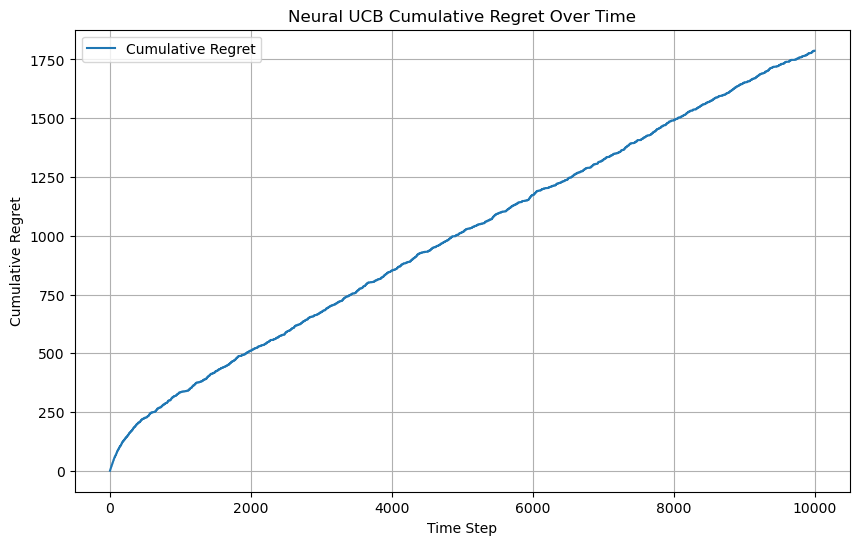

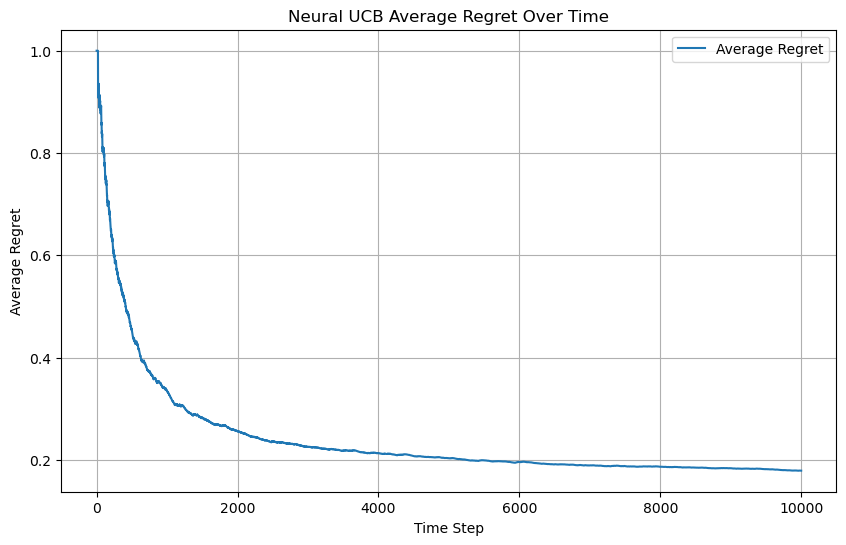

In [7]:
import matplotlib.pyplot as plt

def plot_regret(regret):
    # Convert to numpy array if it's a list
    regret = np.array(regret)
    
    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    cumulative_regret = np.cumsum(regret)
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')
    plt.title('Neural UCB Cumulative Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot average regret
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, len(cumulative_regret) + 1)  # create step array first
    average_regret = cumulative_regret / steps
    plt.plot(average_regret, label='Average Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Average Regret')
    plt.title('Neural UCB Average Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
# After training:
plot_regret(regret)